In [1]:
# imports - have to read the data, run individual steps, and show the results
from pybob.GeoImg import GeoImg
import pybob.coreg_tools as ct
from pybob.plot_tools import set_pretty_fonts
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from osgeo import gdal

plt.ion()
set_pretty_fonts(font_size=18)
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def plot_shared_scale(rasters, titles, scale=1, nodata=np.nan, figsize=(10,5)):
    rasters = [r.ReadAsArray() for r in rasters]
    rasters = [np.where(r==nodata, np.nan, r) for r in rasters]
    n = len(rasters)
    fig, axes = plt.subplots(nrows=1, ncols=n, sharex=True, sharey=True, figsize=figsize)
    for ax,raster,title in zip(axes.flat, rasters, titles):
        im = ax.imshow(raster)
        ax.set_title(title)
    cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    plt.colorbar(im, cax=cax)
    plt.show()

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_separate_scale(raster1, raster2, title1, title2, figsize=(10,5)):
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=figsize)
    ax1, ax2 = axes
    im1 = ax1.imshow(raster1)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = fig.colorbar(im1, cax=cax, orientation='vertical')

    im2 = ax2.imshow(raster2)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = fig.colorbar(im2, cax=cax, orientation='vertical');

In [4]:
old_fn = '../data/processed/wa_state_lidar_datasets/merged/dtm.tif'
new_fn = '../data/processed/rainier_lidar_datasets_dispersed/merged/dtm_2007.tif'

## Prepare Data
We load nearly raw data (we merged stuff in the merge script)

In [5]:
old_dem = GeoImg(gdal.Open(old_fn), datestr='01/01/2001')
new_dem = GeoImg(gdal.Open(new_fn))

### Insert missing no data vlue
I know the no data value is really 0 here...

In [6]:
old_dem.gd.GetRasterBand(1).GetNoDataValue(), new_dem.gd.GetRasterBand(1).GetNoDataValue()

(None, None)

In [7]:
old_dem.gd.GetRasterBand(1).SetNoDataValue(0)
new_dem.gd.GetRasterBand(1).SetNoDataValue(0)

0

In [8]:
old_dem.gd.GetRasterBand(1).GetNoDataValue(), new_dem.gd.GetRasterBand(1).GetNoDataValue()

(0.0, 0.0)

### Re-project 2007 image to the resolution of the 2001 image

In [9]:
new_dem = new_dem.reproject(old_dem)

### Crop Rasters to AOI 
We have an existing shapefile respresenting our AOI (aio.geojson).
The GDAL operation will right to files.

In [10]:
new_dem_final_fn = '2007_final.tif'
old_dem_final_fn = '2001_final.tif'

In [11]:
%%time
old_dem_dataset_cropped = gdal.Warp(old_dem_final_fn,
                         old_dem.gd,
                         cutlineDSName='aoi.geojson',
                         cropToCutline=True,
                         dstNodata = 0)

CPU times: user 376 ms, sys: 164 ms, total: 541 ms
Wall time: 574 ms


In [12]:
%%time
new_dem_dataset_cropped = gdal.Warp(new_dem_final_fn,
                    new_dem.gd,
                    cutlineDSName='aoi.geojson',
                    cropToCutline=True,
                    dstNodata = 0)

CPU times: user 335 ms, sys: 101 ms, total: 436 ms
Wall time: 437 ms


In [13]:
%%time
old_dem = GeoImg(old_dem_dataset_cropped)
new_dem = GeoImg(new_dem_dataset_cropped)

CPU times: user 46.7 ms, sys: 60.1 ms, total: 107 ms
Wall time: 106 ms


### Convert 2007 data from feet to meters

In [14]:
FEET_TO_METERS = 0.3048
new_dem = new_dem.copy(new_raster = new_dem.img * FEET_TO_METERS)

## Look at DEMS

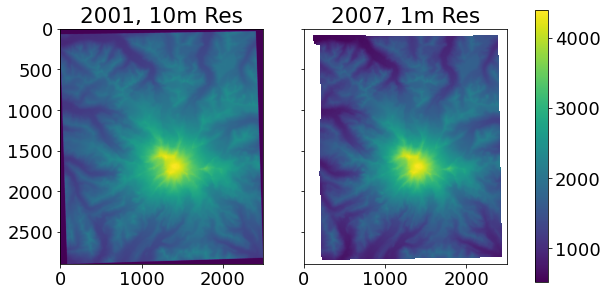

In [15]:
plot_shared_scale([old_dem.gd, new_dem.gd], ['2001, 10m Res','2007, 1m Res'])

## Choose Master and Slave
"Slave" images are shifted to the "truth" of the "Master" image.

Pybob's `preprocess` method also treats the "Master" image as the newer image (slave is subtracted from master"
Master should be the more accurate DEM.

In [16]:
master_new_dem = new_dem.copy()
slave_old_dem = old_dem.copy()

In [17]:
slope_geoimg = ct.get_slope(master_new_dem)
aspect_geoimg = ct.get_aspect(master_new_dem)

In [18]:
slope_geoimg.gd.GetRasterBand(1).GetNoDataValue(), aspect_geoimg.gd.GetRasterBand(1).GetNoDataValue()

(-9999.0, -9999.0)

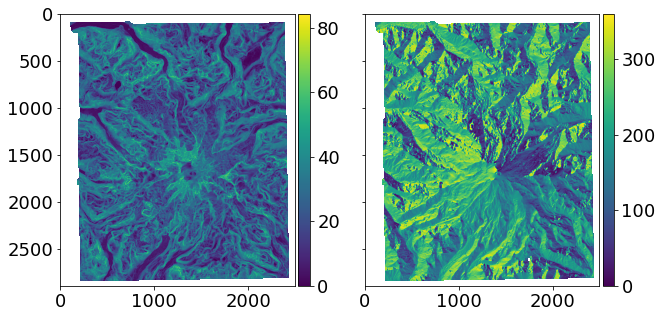

In [19]:
plot_separate_scale(slope_geoimg.img, aspect_geoimg.img, 'Slope', 'Aspect')

## First Look at DEM Difference

In [20]:
init_dh_geoimg = slave_old_dem.copy(new_raster=master_new_dem.img - slave_old_dem.img)

/Users/elischwat/miniconda3/lib/python3.7/site-packages/pybob/GeoImg.py:345: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()  # don't forget this one!


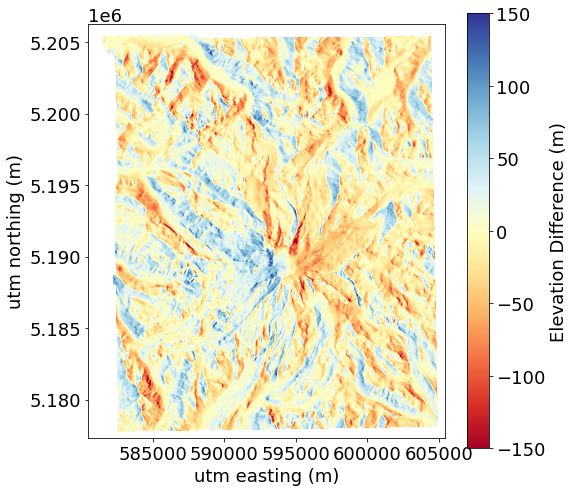

In [21]:
# display the new difference image. for more info, see the documentation
fig1 = init_dh_geoimg.display(fig=plt.figure(figsize=(8,8)), cmap='RdYlBu', vmin=-150, vmax=150)
fig1.gca().set_xlabel('utm easting (m)')
fig1.gca().set_ylabel('utm northing (m)')
# add a colorbar and set the label
cb = plt.colorbar(); cb.set_label('Elevation Difference (m)')
plt.show()

### Examine Distributions of Aspect and Elevation Diff (divided by tan of slope) with Raw Data

In [22]:
aspect_diff_df = pd.DataFrame({
    'aspect': aspect_geoimg.img.flatten(), 
    'diff': init_dh_geoimg.img.flatten(),
    'y': np.divide(init_dh_geoimg.img.flatten(), np.tan(np.radians(slope_geoimg.img)).astype(np.float32).flatten())
})
aspect_diff_df['bin'] = pd.cut(aspect_diff_df.aspect, 10)
aspect_diff_df['bin_equal'] = pd.qcut(aspect_diff_df.aspect, 10)

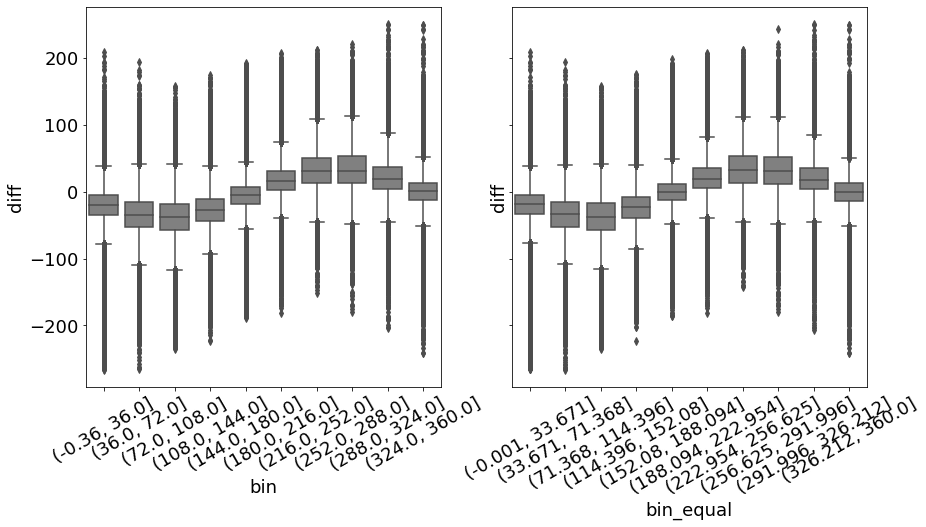

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14,7), sharey=True)
sns.boxplot(ax=axes[0], x='bin', y='diff', data=aspect_diff_df, color='grey')
sns.boxplot(ax=axes[1],x='bin_equal', y='diff', data=aspect_diff_df, color='grey')
for ax in axes:
    ax.set_xticklabels(rotation=30, labels=ax.get_xticklabels())
plt.show()

## First Iteration

In [24]:
this_slave = slave_old_dem.copy()

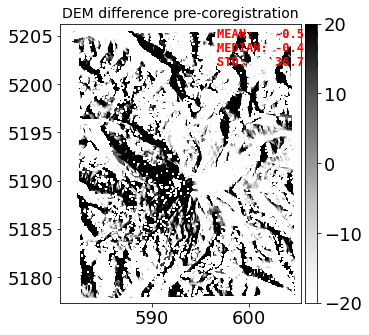

In [25]:
# We start with a mask that is false everywhere, so that ALL pixels are considered (pixel is masked if mask array says True)
mask = np.full(master_new_dem.img.shape, False)
dH, xdata, ydata, sdata = ct.preprocess(mask, slope_geoimg.img, aspect_geoimg.img, master_new_dem, this_slave)
fig3 = ct.false_hillshade(dH, 'DEM difference pre-coregistration')

### Initialize the shift variables

In [26]:
x_shift = y_shift = z_shift = 0

### Calculate the first round of the shifts

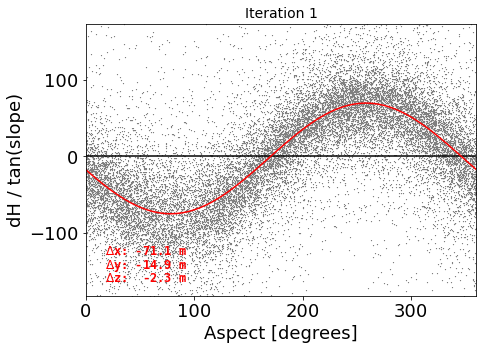

In [27]:
xadj, yadj, zadj, fig2 = ct.coreg_fitting(xdata, ydata, sdata, 'Iteration 1')

### Apply the shift

In [28]:
x_shift += xadj
y_shift += yadj
z_shift += zadj

print(x_shift, y_shift, z_shift)

this_slave.shift(xadj, yadj)
this_slave = this_slave.copy(new_raster=this_slave.img + zadj) # shift the DEM in the z direction

# MIGHT DOING THIS MULTIPLE TIMES INTRODUCE ERROR (this is the second time)??
this_slave = this_slave.reproject(master_new_dem) # re-align the grid of the master, slave DEMs after shifting

-71.12909667794615 -14.880528820742663 -2.2709277100801386


### Examine data post coregistration

In [29]:
# Again, use mask that is false everywhere (ALL pixels considered)
mask = np.full(master_new_dem.img.shape, False)
dH, xdata, ydata, sdata = ct.preprocess(mask, slope_geoimg.img, aspect_geoimg.img, master_new_dem, this_slave)
# fig4 = ct.false_hillshade(dH, 'DEM difference after first iteration.')

## Second Iteration
Adjust shift variables, calculate this round of shifts, apply the shifts

-89.40733508017202 -18.16467820477168 -0.8374415344230821


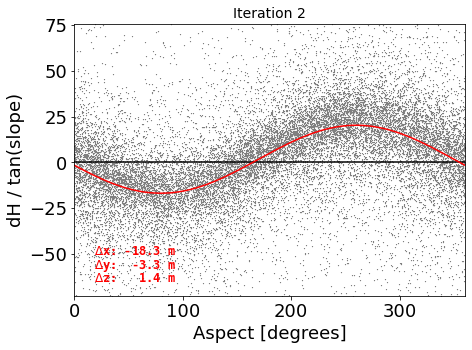

In [30]:
xadj, yadj, zadj, fig5 = ct.coreg_fitting(xdata, ydata, sdata, 'Iteration 2')

x_shift += xadj
y_shift += yadj
z_shift += zadj

print(x_shift, y_shift, z_shift)

this_slave.shift(xadj, yadj)

this_slave = this_slave.reproject(master_new_dem)
this_slave = this_slave.copy(new_raster=this_slave.img + zadj) # shift the DEM in the z direction

# Again, use mask that is false everywhere (ALL pixels considered
mask = np.full(master_new_dem.img.shape, False)
dH, xdata, ydata, sdata = ct.preprocess(mask, slope_geoimg.img, aspect_geoimg.img, master_new_dem, this_slave)
# fig4 = ct.false_hillshade(dH, 'DEM difference after second iteration.')

## Third Iteration

-91.69846482350177 -18.433160695541577 -0.5578897964461331


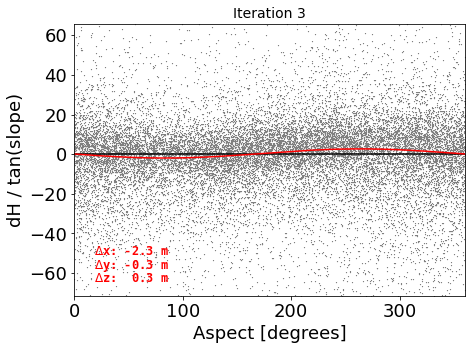

In [31]:
H, xdata, ydata, sdata = ct.preprocess(np.ones(master_new_dem.img.shape) == 0, slope_geoimg.img, aspect_geoimg.img, master_new_dem, this_slave)
xadj, yadj, zadj, fig5 = ct.coreg_fitting(xdata, ydata, sdata, 'Iteration 3')

x_shift += xadj
y_shift += yadj
z_shift += zadj

print(x_shift, y_shift, z_shift)

this_slave.shift(xadj, yadj)

this_slave = this_slave.reproject(master_new_dem)
this_slave = this_slave.copy(new_raster=this_slave.img + zadj) # shift the DEM in the z direction

# Again, use mask that is false everywhere (ALL pixels considered
mask = np.full(master_new_dem.img.shape, False)
dH, xdata, ydata, sdata = ct.preprocess(mask, slope_geoimg.img, aspect_geoimg.img, master_new_dem, this_slave)
# fig5 = ct.false_hillshade(dH, 'DEM difference after third iteration.')

## Fourth Iteration

-92.06170700873766 -18.61436598848569 -0.5616236413480444


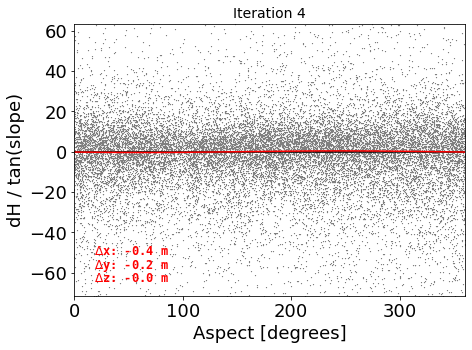

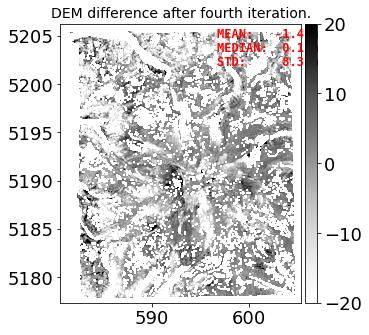

In [32]:
H, xdata, ydata, sdata = ct.preprocess(np.ones(master_new_dem.img.shape) == 0, slope_geoimg.img, aspect_geoimg.img, master_new_dem, this_slave)
xadj, yadj, zadj, fig5 = ct.coreg_fitting(xdata, ydata, sdata, 'Iteration 4')

x_shift += xadj
y_shift += yadj
z_shift += zadj

print(x_shift, y_shift, z_shift)

this_slave.shift(xadj, yadj)

this_slave = this_slave.reproject(master_new_dem)
this_slave = this_slave.copy(new_raster=this_slave.img + zadj) # shift the DEM in the z direction

# Again, use mask that is false everywhere (ALL pixels considered
mask = np.full(master_new_dem.img.shape, False)
dH, xdata, ydata, sdata = ct.preprocess(mask, slope_geoimg.img, aspect_geoimg.img, master_new_dem, this_slave)
fig5 = ct.false_hillshade(dH, 'DEM difference after fourth iteration.')

([-1.4138166, 0.080566406, 8.312669, 8.432042, 5888669],
 [-0.60399354, -0.42419434, 36.195793, 36.200836, 6130976])

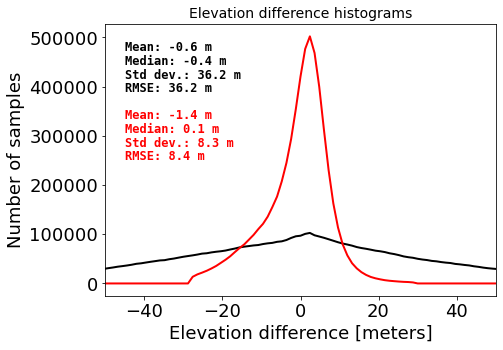

In [79]:
ct.final_histogram(init_dh_geoimg.img, dH.img) # plot the difference distributions between the two DEMs pre- and post- co-registration.

/Users/elischwat/miniconda3/lib/python3.7/site-packages/pybob/GeoImg.py:345: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()  # don't forget this one!


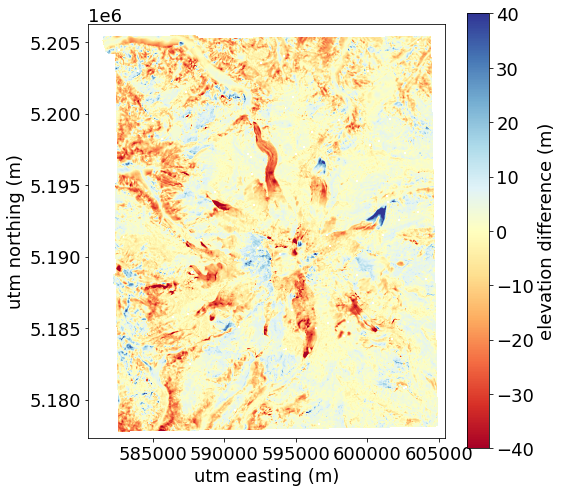

In [34]:
final_dh_geo = this_slave.copy(new_raster=master_new_dem.img - this_slave.img)

# display the new difference image. for more info, see the documentation
fig1 = final_dh_geo.display(fig=plt.figure(figsize=(8,8)), cmap='RdYlBu', vmin=-40, vmax=40)
fig1.gca().set_xlabel('utm easting (m)')
fig1.gca().set_ylabel('utm northing (m)')

# add a colorbar and set the label
cb = plt.colorbar(); cb.set_label('elevation difference (m)')

In [35]:
final_dh_geo.write('dh_2001_2007.tif')

### Plot Init DH and Final DH 

In [80]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plotter(raster1, raster2, title1, title2, figsize=(10,5)):
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=figsize)
    ax1, ax2 = axes
    im1 = ax1.imshow(raster1, cmap='RdYlBu', vmin=-150, vmax=150)

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = fig.colorbar(im1, cax=cax, orientation='vertical')

    im2 = ax2.imshow(raster2, cmap='RdYlBu', vmin=-40, vmax=40)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = fig.colorbar(im2, cax=cax, orientation='vertical')
    
    [ax.set_xticks([]) for ax in axes]
    [ax.set_yticks([]) for ax in axes]
    plt.tight_layout()

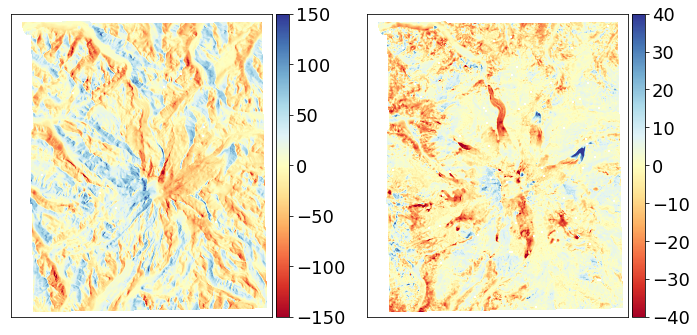

In [81]:
plotter(init_dh_geoimg.img, final_dh_geo.img,'','')